In [2]:
# Do it by myself

pip install -q diffusers

In [3]:
import torch
import torchvision
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from diffusers import DDPMScheduler, UNet2DModel
from matplotlib import pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

Using device: cuda


In [4]:
dataset = torchvision.datasets.MNIST(root="mnist/", train=True, download=True, transform=torchvision.transforms.ToTensor())

In [5]:
train_dataloader = DataLoader(dataset, batch_size=8, shuffle=True)

Input shape: torch.Size([8, 1, 28, 28])
Labels: tensor([5, 3, 8, 3, 4, 7, 1, 2])


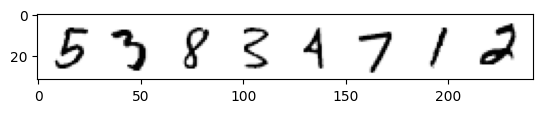

In [6]:
x, y = next(iter(train_dataloader))
print('Input shape:', x.shape)
print('Labels:', y)
plt.imshow(torchvision.utils.make_grid(x)[0], cmap='Greys');

我其實沒有學過diffusion
但是逐步添加高斯噪声來生成新的數據，
`noise = torch.rand_like(x)` 噪音
`noisy_x =  (1-amount)*x + amount*noise` 加噪

In [7]:
def corrupt(x, amount):
  """Corrupt the input `x` by mixing it with noise according to `amount`"""
  noise = torch.rand_like(x)
  amount = amount.view(-1, 1, 1, 1) # Sort shape so broadcasting works
  return x*(1-amount) + noise*amount 

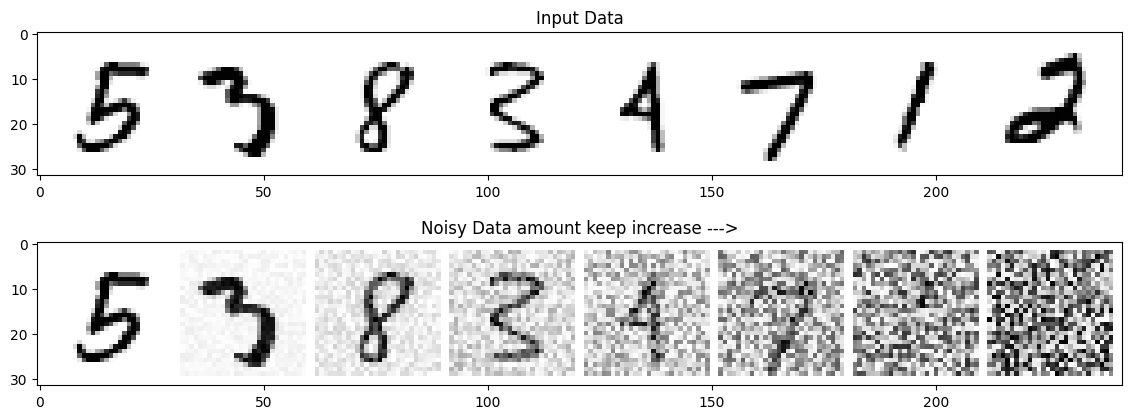

In [8]:
fig, axs = plt.subplots(2, 1, figsize=(14, 5))
axs[0].set_title('Input Data')
axs[0].imshow(torchvision.utils.make_grid(x)[0], cmap='Greys')

# add noise
amount = torch.linspace(0, 1, x.shape[0])
noisy_x = corrupt(x, amount)

# 新圖像
axs[1].set_title('Noisy Data amount keep increase --->')
axs[1].imshow(torchvision.utils.make_grid(noisy_x)[0], cmap='Greys')

In [9]:
# unet
class UNet(nn.Module):
    def __init__(self, in_channels = 1, out_channels = 1):
        super().__init__()
        self.down_layers = torch.nn.ModuleList([
            nn.Conv2d(in_channels, 32, kernel_size=5, padding=2),
            nn.Conv2d(32, 64, kernel_size=5, padding=2),
            nn.Conv2d(64, 64, kernel_size=5, padding=2)
        ])
        self.up_layers = torch.nn.ModuleList([
            nn.Conv2d(64, 64, kernel_size=5, padding=2),
            nn.Conv2d(64, 32, kernel_size=5, padding=2),
            nn.Conv2d(32, out_channels, kernel_size=5, padding=2)
        ])
        self.act = nn.SiLU()
        self.downscale = nn.MaxPool2d(2)
        self.upscale = nn.Upsample(scale_factor=2)
    def forward(self, x):
        h = []
        for i, l in enumerate(self.down_layers):
            x = self.act(l(x))
            if i < 2: # For all but the third (final) down layer:
                h.append(x) # Storing the output of each down layer for skpping(可以先存起來)
                x = self.downscale(x) 
        for i, l in enumerate(self.up_layers):
            if i > 0: # For all except the first up layer
                x = self.upscale(x)
                x += h.pop() # 最後把存起來的數據再相加回去
            x = self.act(l(x))
        return x

In [10]:
unet = UNet()
x  = torch.rand(8, 1, 28, 28)
unet(x).shape

torch.Size([8, 1, 28, 28])

In [11]:
t = 0
for p in unet.parameters():
    t += p.numel();

# Training the network

Epoch 1, Loss: 0.0287
Epoch 2, Loss: 0.0213
Epoch 3, Loss: 0.0194


(0.0, 0.1)

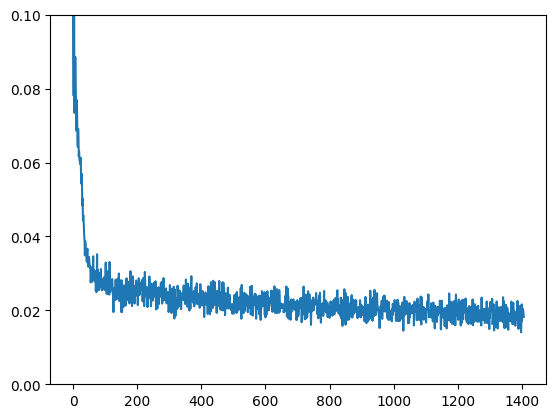

In [12]:
batch_size = 128
train_dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# run 3 times
n_epochs = 3

# Create the network
net = UNet()
net.to(device)

# optim
opt = torch.optim.Adam(net.parameters(), lr=1e-3)

# loss function
loss_fn = nn.MSELoss()

# loss
losses = []

for epoch in range(n_epochs):
    for i, (x, y) in enumerate(train_dataloader):
        x = x.to(device)
        noise_amout = torch.rand(x.shape[0]).to(device)
        noisy_x = corrupt(x, noise_amout)
        
        # pred
        pred = net(noisy_x)
        loss = loss_fn(pred, x)
        opt.zero_grad()
        loss.backward()
        opt.step()

        losses.append(loss.item())
    total_loss = 0
    for loss in losses[-len(train_dataloader):]:
        total_loss += loss
    avg_loss = total_loss / len(train_dataloader)
    print(f'Epoch {epoch+1}, Loss: {avg_loss:.4f}')

plt.plot(losses)
plt.ylim(0, 0.1)

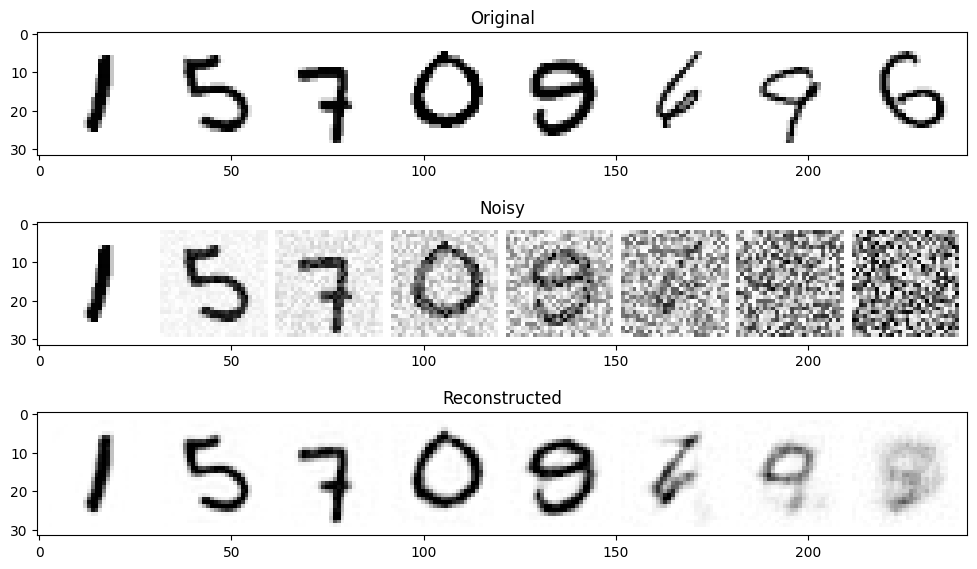

In [13]:
# Fetch some data
x, y = next(iter(train_dataloader))
x = x[:8] # only first 8 images

amount = torch.linspace(0, 1, x.shape[0])
noised_x = corrupt(x, amount)

with torch.no_grad():
    pred = net(noised_x.to(device)).detach().cpu()

# plot
fig, axs = plt.subplots(3, 1, figsize=(12, 7))
axs[0].set_title('Original')
axs[0].imshow(torchvision.utils.make_grid(x)[0].clip(0, 1), cmap='Greys')

axs[1].set_title('Noisy')
axs[1].imshow(torchvision.utils.make_grid(noised_x)[0].clip(0, 1), cmap='Greys')

axs[2].set_title('Reconstructed')
axs[2].imshow(torchvision.utils.make_grid(pred)[0].clip(0, 1), cmap='Greys')

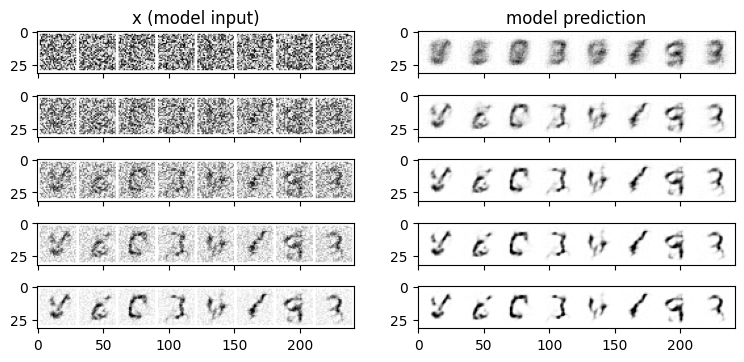

In [14]:
n_steps = 5
x = torch.rand(8, 1, 28, 28).to(device) # Start from random
step_history = [x.detach().cpu()]
pred_output_history = []

for i in range(n_steps):
    with torch.no_grad(): # No need to track gradients during inference
        pred = net(x) # Predict the denoised x0
    pred_output_history.append(pred.detach().cpu()) # Store model output for plotting
    mix_factor = 1/(n_steps - i) # How much we move towards the prediction
    x = x*(1-mix_factor) + pred*mix_factor # Move part of the way there
    step_history.append(x.detach().cpu()) # Store step for plotting

fig, axs = plt.subplots(n_steps, 2, figsize=(9, 4), sharex=True)
axs[0,0].set_title('x (model input)')
axs[0,1].set_title('model prediction')
for i in range(n_steps):
    axs[i, 0].imshow(torchvision.utils.make_grid(step_history[i])[0].clip(0, 1), cmap='Greys')
    axs[i, 1].imshow(torchvision.utils.make_grid(pred_output_history[i])[0].clip(0, 1), cmap='Greys')

In [15]:
model = UNet2DModel(
    sample_size=28,
    in_channels=1,
    out_channels=1,
    layers_per_block=3,
    block_out_channels=(32,64,64),
    down_block_types=(
        "DownBlock2D",
        "AttnDownBlock2D",
        "AttnDownBlock2D",
    ),
    up_block_types=(
        "AttnUpBlock2D",
        "AttnUpBlock2D",
        "UpBlock2D",
    )
)
print(model)

UNet2DModel(
  (conv_in): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (time_proj): Timesteps()
  (time_embedding): TimestepEmbedding(
    (linear_1): Linear(in_features=32, out_features=128, bias=True)
    (act): SiLU()
    (linear_2): Linear(in_features=128, out_features=128, bias=True)
  )
  (down_blocks): ModuleList(
    (0): DownBlock2D(
      (resnets): ModuleList(
        (0-2): 3 x ResnetBlock2D(
          (norm1): GroupNorm(32, 32, eps=1e-05, affine=True)
          (conv1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (time_emb_proj): Linear(in_features=128, out_features=32, bias=True)
          (norm2): GroupNorm(32, 32, eps=1e-05, affine=True)
          (dropout): Dropout(p=0.0, inplace=False)
          (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (nonlinearity): SiLU()
        )
      )
      (downsamplers): ModuleList(
        (0): Downsample2D(
          (conv): Conv2d(32, 32, ker

In [16]:
# 1.7M vs the ~309k parameters of the BasicUNet
t = 0
for p in model.parameters():
    t += p.numel()
print(f"Total parameters: {t}")

Total parameters: 2250913


f:\python3.10\lib\site-packages\diffusers\models\attention_processor.py:2383: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:555.)
  hidden_states = F.scaled_dot_product_attention(


Finished epoch 0. Average loss: 0.018713
Finished epoch 1. Average loss: 0.012538
Finished epoch 2. Average loss: 0.011349


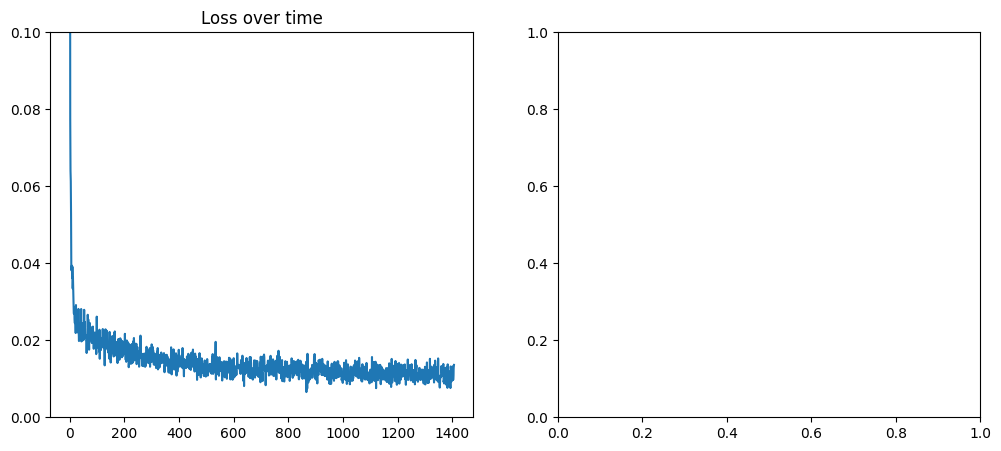

In [17]:
batch_size = 128
train_dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

n_epochs = 3

net = UNet2DModel(
    sample_size=28,
    in_channels=1,
    out_channels=1,
    layers_per_block=2,
    block_out_channels=(32,64,64),
    down_block_types=(
        "DownBlock2D",
        "AttnDownBlock2D",
        "AttnDownBlock2D",
    ),
    up_block_types=(
        "AttnUpBlock2D",
        "AttnUpBlock2D",
        "UpBlock2D",
    )
)
net.to(device)

loss_fn = nn.MSELoss()
opt = torch.optim.Adam(net.parameters(), lr=1e-3)

losses = []
for epoch in range(n_epochs):
    for x, y in train_dataloader:
        x = x.to(device)
        noise = torch.rand(x.shape[0]).to(device)
        noisy_x = corrupt(x, noise)

        pred = net(noisy_x, 0).sample

        loss = loss_fn(pred, x)

        opt.zero_grad()
        loss.backward()
        opt.step()
        losses.append(loss.item())
    total_loss = 0
    for loss in losses[-len(train_dataloader):]:
        total_loss += loss
    avg_loss = total_loss / len(train_dataloader)
    print(f'Finished epoch {epoch}. Average loss: {avg_loss:05f}')
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

axs[0].plot(losses)
axs[0].set_ylim(0, 0.1)
axs[0].set_title('Loss over time')

n_steps = 40
x = torch.rand(64, 1, 28, 28).to(device)
for i in range(n_steps):
    noise = torch.ones((x.shape[0])).to(device) * (1 - (i / n_steps))
    with torch.no_grad():
        pred = net(x, noise).sample
    mix = 1 / (n_steps - i)
    x = x * (1 - mix) + pred * mix

Text(0.5, 1.0, 'Generated Samples')

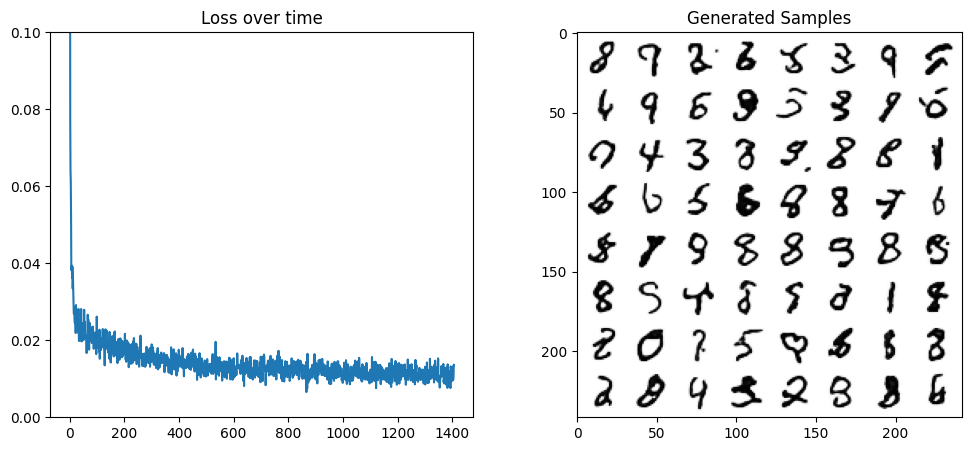

In [18]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

axs[0].plot(losses)
axs[0].set_ylim(0, 0.1)
axs[0].set_title('Loss over time')

n_steps = 40
x = torch.rand(64, 1, 28, 28).to(device)
for i in range(n_steps):
    noise = torch.ones((x.shape[0])).to(device) * (1 - (i / n_steps))
    with torch.no_grad():
        pred = net(x, noise).sample
    mix = 1 / (n_steps - i)
    x = x * (1 - mix) + pred * mix
axs[1].imshow(torchvision.utils.make_grid(x.detach().cpu(), nrow=8)[0].clip(0, 1), cmap='Greys')
axs[1].set_title('Generated Samples')

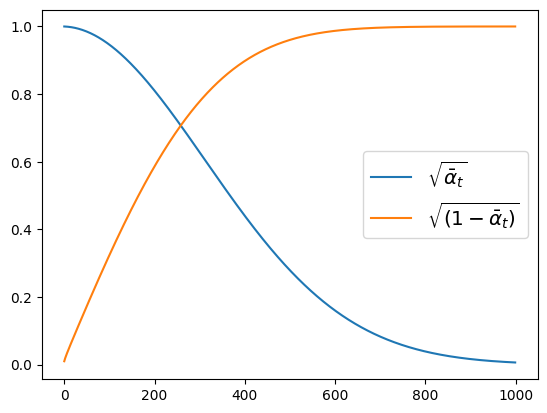

In [19]:
noise_scheduler = DDPMScheduler(beta_start=0.0001, beta_end=0.02,num_train_timesteps=1000)
plt.plot(noise_scheduler.alphas_cumprod.cpu() ** 0.5, label=r"${\sqrt{\bar{\alpha}_t}}$")
plt.plot((1 - noise_scheduler.alphas_cumprod.cpu()) ** 0.5, label=r"$\sqrt{(1 - \bar{\alpha}_t)}$")
plt.legend(fontsize="x-large");

Initially, the noisy x is mostly x (sqrt_alpha_prod ~= 1) but over time the contribution of x drops and the noise component increases. Unlike our linear mix of x and noise according to amount, this one gets noisy relatively quickly. We can visualize this on some data:



X shape torch.Size([8, 1, 28, 28])
Noisy X shape torch.Size([8, 1, 28, 28])


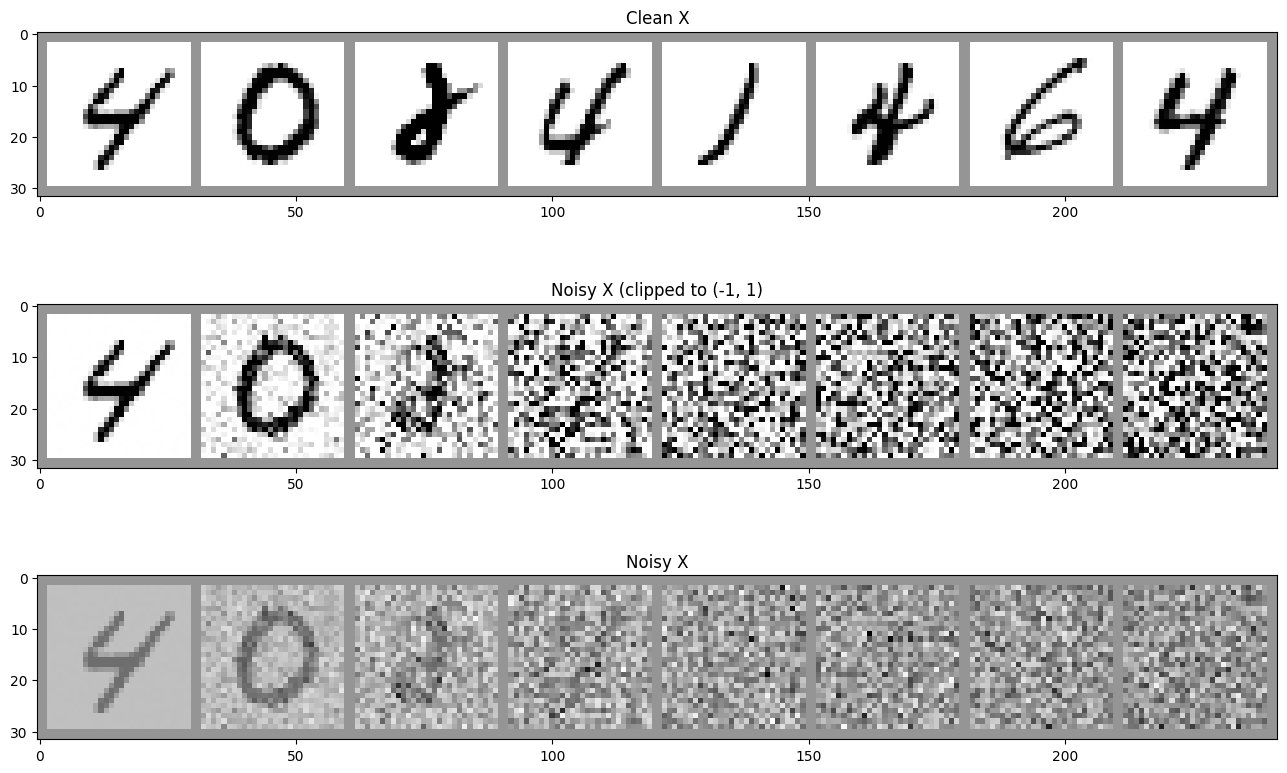

In [20]:
# Noise a batch of images to view the effect
fig, axs = plt.subplots(3, 1, figsize=(16, 10))
xb, yb = next(iter(train_dataloader))
xb = xb.to(device)[:8]
xb = xb * 2. - 1. # Map to (-1, 1)
print('X shape', xb.shape)

# Show clean inputs
axs[0].imshow(torchvision.utils.make_grid(xb[:8])[0].detach().cpu(), cmap='Greys')
axs[0].set_title('Clean X')

# Add noise with scheduler
timesteps = torch.linspace(0, 999, 8).long().to(device)
noise = torch.randn_like(xb) # << NB: randn not rand
noisy_xb = noise_scheduler.add_noise(xb, noise, timesteps)
print('Noisy X shape', noisy_xb.shape)

# Show noisy version (with and without clipping)
axs[1].imshow(torchvision.utils.make_grid(noisy_xb[:8])[0].detach().cpu().clip(-1, 1),  cmap='Greys')
axs[1].set_title('Noisy X (clipped to (-1, 1)')
axs[2].imshow(torchvision.utils.make_grid(noisy_xb[:8])[0].detach().cpu(),  cmap='Greys')
axs[2].set_title('Noisy X');

Another dynamic at play: the DDPM version adds noise drawn from a Gaussian distribution (mean 0, s.d. 1 from torch.randn) rather than the uniform noise between 0 and 1 (from torch.rand) we used in our original corrupt function. In general, it makes sense to normalize the training data as well. In the other notebook, you'll see Normalize(0.5, 0.5) in the list of transforms, which maps the image data form (0, 1) to (-1, 1) and is 'good enough' for our purposes. We didn't do that for this notebook, but the visualization cell above adds it in for more accurate scaling and visualization.